In [1]:
!gdown --id 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8
From (redirected): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8&confirm=t&uuid=a5c7447f-40e5-4254-9723-7ee0e41025d6
To: /content/FER-2013.zip
100% 63.3M/63.3M [00:01<00:00, 32.3MB/s]


In [2]:
!unzip -q '/content/FER-2013.zip'


In [3]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image
from sklearn.model_selection import train_test_split


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)


In [5]:
train_dir = '/content/train'
test_dir = '/content/test'

classes = os.listdir(train_dir)
label2idx = {cls: idx for idx, cls in enumerate(classes)}
idx2label = {idx: cls for cls, idx in label2idx.items()}


In [12]:
test_img_path = '/content/train/angry/Training_10118481.jpg'  # Đường dẫn đến ảnh
img = cv2.imread(test_img_path)  # Đọc ảnh bằng OpenCV
img_height, img_width = (128, 128)  # Kích thước ảnh chuẩn
print(f'Image height: {img_height}')  # In chiều cao ảnh
print(f'Image width: {img_width}')  # In chiều rộng ảnh


Image height: 128
Image width: 128


In [13]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx, split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))  # Kích thước chuẩn hóa ảnh
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_paths, self.img_labels = self.read_img_files()

        # Chia dữ liệu thành tập train/val
        if split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size=train_ratio,
                random_state=random_state,
                stratify=self.img_labels
            )
            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == 'val':
                self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self):
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)
        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))  # Đọc và resize ảnh
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img / 127.5) - 1  # Chuẩn hóa ảnh về [-1, 1]
        return img, label


In [14]:
batch_size = 256

# Tập train
train_dataset = ImageDataset(train_dir, True, label2idx, split='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Tập validation
val_dataset = ImageDataset(train_dir, True, label2idx, split='val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Tập test
test_dataset = ImageDataset(test_dir, True, label2idx, split='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


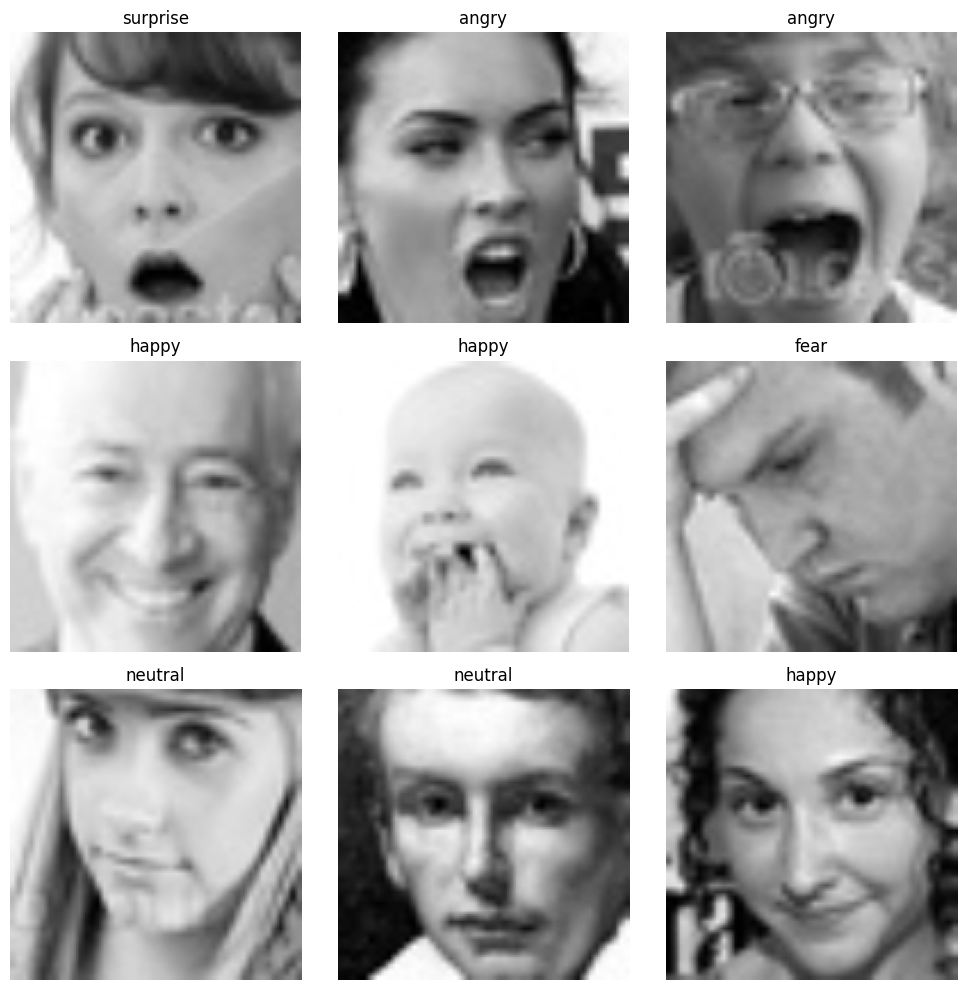

In [16]:
image_batch, label_batch = next(iter(train_loader))  # Lấy một batch ảnh từ train_loader

plt.figure(figsize=(10, 10))  # Kích thước hình vẽ
for i in range(9):  # Hiển thị 9 hình đầu tiên
    ax = plt.subplot(3, 3, i + 1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()
    plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap="gray")
    label = label_batch[i]
    plt.title(idx2label[label.item()])  # Lấy tên class từ idx2label
    plt.axis("off")
plt.tight_layout()
plt.show()


In [17]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims * 4)
        self.linear2 = nn.Linear(hidden_dims * 4, hidden_dims * 2)
        self.linear3 = nn.Linear(hidden_dims * 2, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)  # Flatten ảnh thành vector 1D
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out  # Không squeeze, vì đây là bài toán phân loại đa lớp

# Khai báo các tham số
input_dims = img_height * img_width  # Số đặc trưng đầu vào
output_dims = len(classes)  # Số lớp đầu ra
hidden_dims = 64  # Số neuron trong lớp ẩn
lr = 1e-2  # Learning rate

# Khởi tạo mô hình và chuyển về device
model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)


In [18]:
criterion = nn.CrossEntropyLoss()  # Hàm loss cho bài toán phân loại đa lớp
optimizer = torch.optim.SGD(model.parameters(), lr=lr)  # SGD với learning rate lr


In [19]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)  # Lấy chỉ số của lớp dự đoán cao nhất
    correct = (y_hat == y_true).sum().item()  # Đếm số lượng dự đoán đúng
    accuracy = correct / len(y_true)  # Tính tỷ lệ chính xác
    return accuracy


In [20]:
epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []

    # Training phase
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)

        optimizer.zero_grad()
        outputs = model(X_samples)  # Dự đoán
        loss = criterion(outputs, y_samples)  # Tính loss
        loss.backward()  # Lan truyền ngược
        optimizer.step()  # Cập nhật trọng số
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    # Validation phase
    val_loss = 0.0
    val_target = []
    val_predict = []

    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)

            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    # Logging
    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')



EPOCH 1:	Training loss: 1.922	Validation loss: 1.875

EPOCH 2:	Training loss: 1.840	Validation loss: 1.818

EPOCH 3:	Training loss: 1.802	Validation loss: 1.793

EPOCH 4:	Training loss: 1.781	Validation loss: 1.777

EPOCH 5:	Training loss: 1.765	Validation loss: 1.762

EPOCH 6:	Training loss: 1.749	Validation loss: 1.745

EPOCH 7:	Training loss: 1.730	Validation loss: 1.725

EPOCH 8:	Training loss: 1.709	Validation loss: 1.705

EPOCH 9:	Training loss: 1.687	Validation loss: 1.683

EPOCH 10:	Training loss: 1.667	Validation loss: 1.666

EPOCH 11:	Training loss: 1.650	Validation loss: 1.653

EPOCH 12:	Training loss: 1.637	Validation loss: 1.642

EPOCH 13:	Training loss: 1.626	Validation loss: 1.635

EPOCH 14:	Training loss: 1.617	Validation loss: 1.628

EPOCH 15:	Training loss: 1.608	Validation loss: 1.621

EPOCH 16:	Training loss: 1.599	Validation loss: 1.616

EPOCH 17:	Training loss: 1.590	Validation loss: 1.610

EPOCH 18:	Training loss: 1.582	Validation loss: 1.604

EPOCH 19:	Training

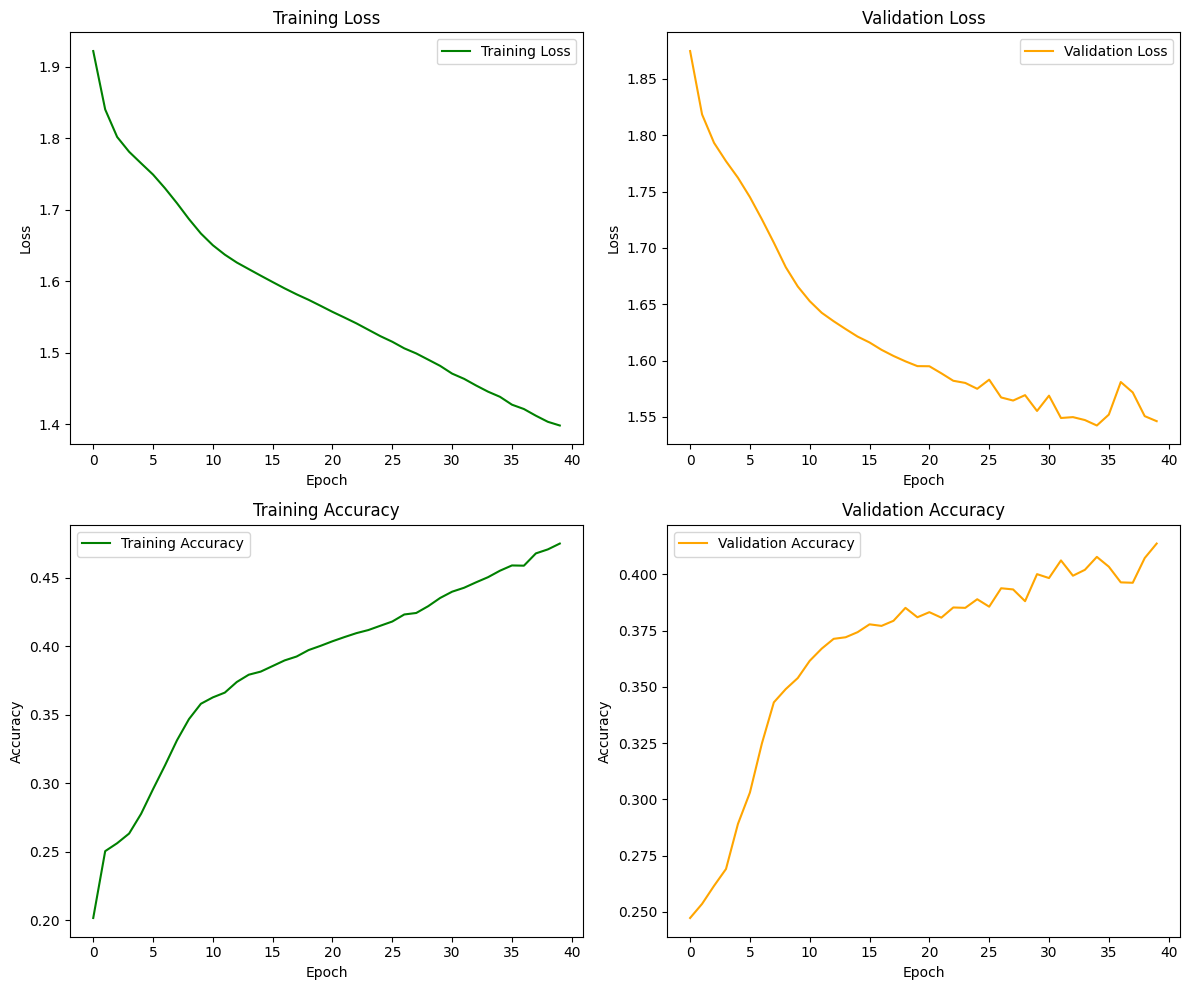

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Training Loss
ax[0, 0].plot(train_losses, color='green', label='Training Loss')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')
ax[0, 0].legend()

# Validation Loss
ax[0, 1].plot(val_losses, color='orange', label='Validation Loss')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')
ax[0, 1].legend()

# Training Accuracy
ax[1, 0].plot(train_accs, color='green', label='Training Accuracy')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')
ax[1, 0].legend()

# Validation Accuracy
ax[1, 1].plot(val_accs, color='orange', label='Validation Accuracy')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')
ax[1, 1].legend()

plt.tight_layout()
plt.show()


In [22]:
test_target = []
test_predict = []

model.eval()  # Đặt mô hình ở chế độ đánh giá
with torch.no_grad():  # Không tính toán gradient
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)  # Chuyển input lên thiết bị
        y_samples = y_samples.to(device)  # Chuyển label lên thiết bị

        outputs = model(X_samples)  # Dự đoán
        test_predict.append(outputs.cpu())  # Chuyển kết quả dự đoán về CPU
        test_target.append(y_samples.cpu())  # Chuyển label về CPU

# Ghép các batch lại thành tensor
test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)

# Tính độ chính xác
test_acc = compute_accuracy(test_predict, test_target)

# In kết quả
print('Evaluation on test set:')
print(f'Accuracy: {test_acc:.2f}')


Evaluation on test set:
Accuracy: 0.41


TEST MINH HOẠ

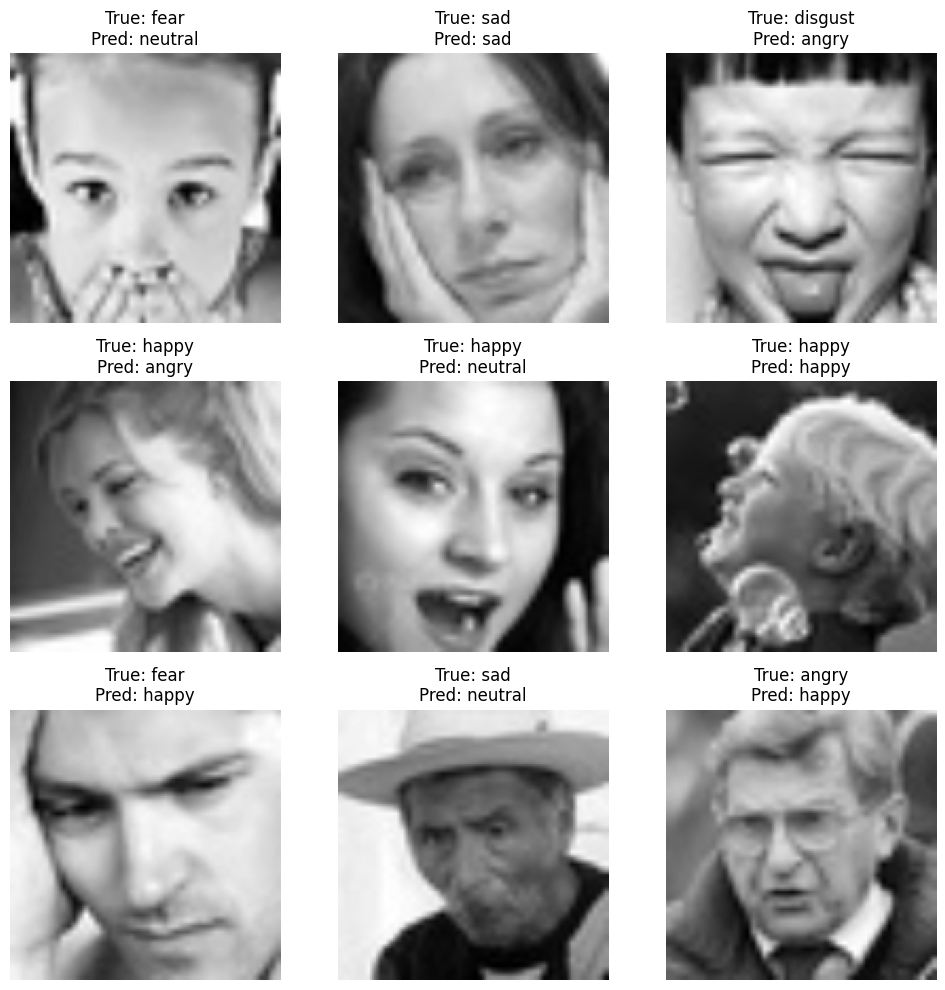

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Lấy nhãn dự đoán
_, predicted_labels = torch.max(test_predict, dim=1)

# Lựa chọn 9 ảnh từ tập test để hiển thị
num_images = 9
indices = np.random.choice(len(test_target), num_images, replace=False)

# Vẽ ảnh
plt.figure(figsize=(10, 10))
for i, idx in enumerate(indices):
    img = test_loader.dataset[idx][0].squeeze().cpu().numpy()  # Ảnh gốc
    true_label = idx2label[test_target[idx].item()]  # Nhãn thực tế
    predicted_label = idx2label[predicted_labels[idx].item()]  # Nhãn dự đoán

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [24]:
true_labels = [idx2label[label.item()] for label in test_target]
predicted_labels = [idx2label[label.item()] for label in predicted_labels]

for i in range(20):  # Hiển thị 20 kết quả đầu tiên
    print(f"Image {i+1}: True = {true_labels[i]}, Predicted = {predicted_labels[i]}")


Image 1: True = happy, Predicted = happy
Image 2: True = happy, Predicted = happy
Image 3: True = happy, Predicted = happy
Image 4: True = happy, Predicted = happy
Image 5: True = happy, Predicted = happy
Image 6: True = happy, Predicted = happy
Image 7: True = happy, Predicted = happy
Image 8: True = happy, Predicted = sad
Image 9: True = happy, Predicted = happy
Image 10: True = happy, Predicted = happy
Image 11: True = happy, Predicted = happy
Image 12: True = happy, Predicted = happy
Image 13: True = happy, Predicted = happy
Image 14: True = happy, Predicted = sad
Image 15: True = happy, Predicted = happy
Image 16: True = happy, Predicted = happy
Image 17: True = happy, Predicted = happy
Image 18: True = happy, Predicted = happy
Image 19: True = happy, Predicted = happy
Image 20: True = happy, Predicted = surprise
